## Импорты и настройки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error
)
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV
from tsai.all import *
from sklearn.preprocessing import LabelEncoder
from tsai.data.core import TSDatasets, TSDataLoaders
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tsai.models.InceptionTime import InceptionTime
from tsai.learner import ts_learner
from tsai.metrics import accuracy


## Загрузка данных

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10320 entries, 2014-07-01 00:00:00 to 2015-01-31 23:30:00
Freq: 30min
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   10320 non-null  int64
dtypes: int64(1)
memory usage: 161.2 KB
None
Минимальный интервал: 0 days 00:30:00
Максимальный интервал: 0 days 00:30:00


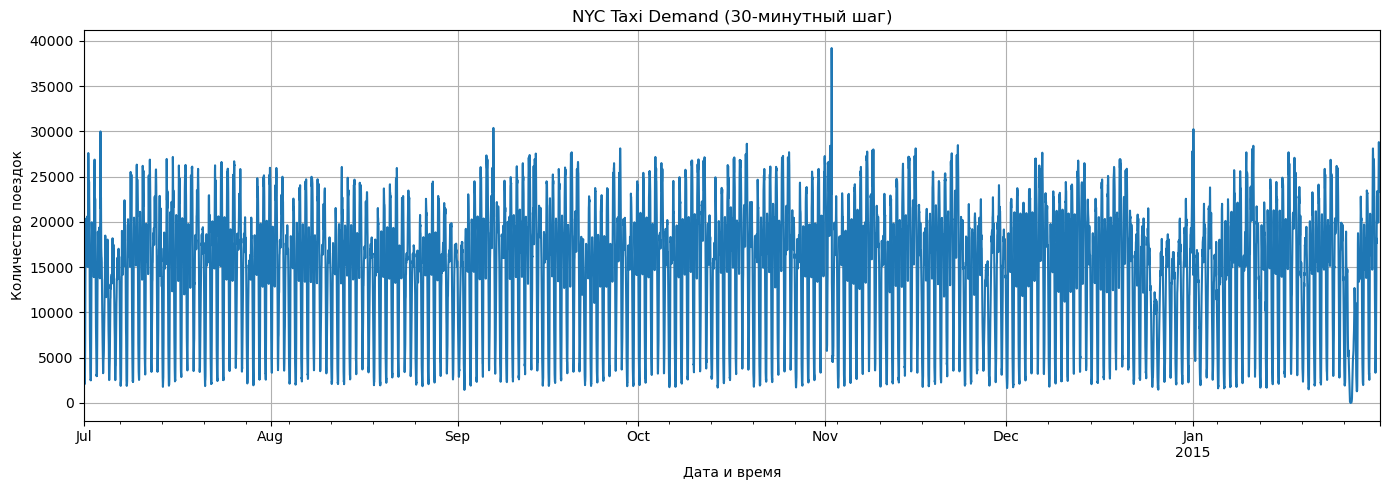

In [2]:
df = pd.read_csv("data/nyc_taxi.txt", sep=",", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)
df.index.freq = "30min"


print(df.info())

intervals = df.index.to_series().diff().dropna()
print("Минимальный интервал:", intervals.min())
print("Максимальный интервал:", intervals.max())

plt.figure(figsize=(14, 5))
df['value'].plot(title="NYC Taxi Demand (30-минутный шаг)")
plt.ylabel("Количество поездок")
plt.xlabel("Дата и время")
plt.grid(True)
plt.tight_layout()
plt.show()


## Предварительный анализ

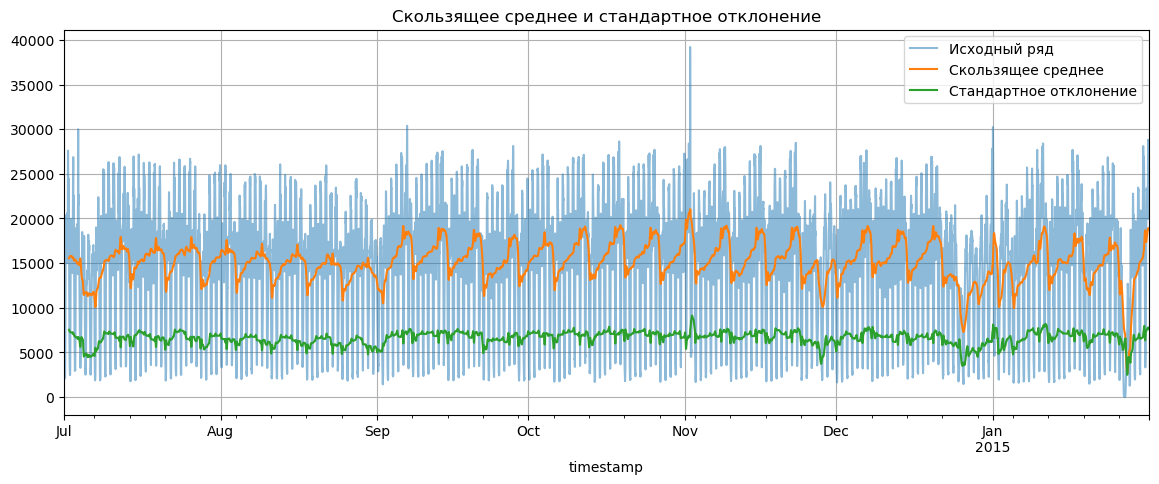

In [3]:
# Скользящее среднее и стандартное отклонение за 1 день
rolling_mean = df["value"].rolling(window=48).mean()
rolling_std = df["value"].rolling(window=48).std()

# График скользящего среднего и стандартного отклонения
plt.figure(figsize=(14, 5))
df["value"].plot(label="Исходный ряд", alpha=0.5)
rolling_mean.plot(label="Скользящее среднее")
rolling_std.plot(label="Стандартное отклонение")
plt.title("Скользящее среднее и стандартное отклонение")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
#ADFuller тест
adf_result = adfuller(df["value"])
print(f"ADF statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Критические значения:")
for key, val in adf_result[4].items():
    print(f"    {key}: {val}")

ADF statistic: -10.76451745401704
p-value: 2.4721317220666326e-19
Критические значения:
    1%: -3.4309862775905664
    5%: -2.8618211976893573
    10%: -2.566919676386092


## Сравнение 3х методов предсказаний


Наивный
MAE:  13156.440476190477
RMSE: 15292.343161888317
MAPE: 5142.449694306302

Скользящее среднее
MAE:  7175.906994047619
RMSE: 8810.730819836292
MAPE: 3278.1403876784716

Экспоненциальное сглаживание
MAE:  11312.881326946892
RMSE: 13535.37850912649
MAPE: 4716.666173459538


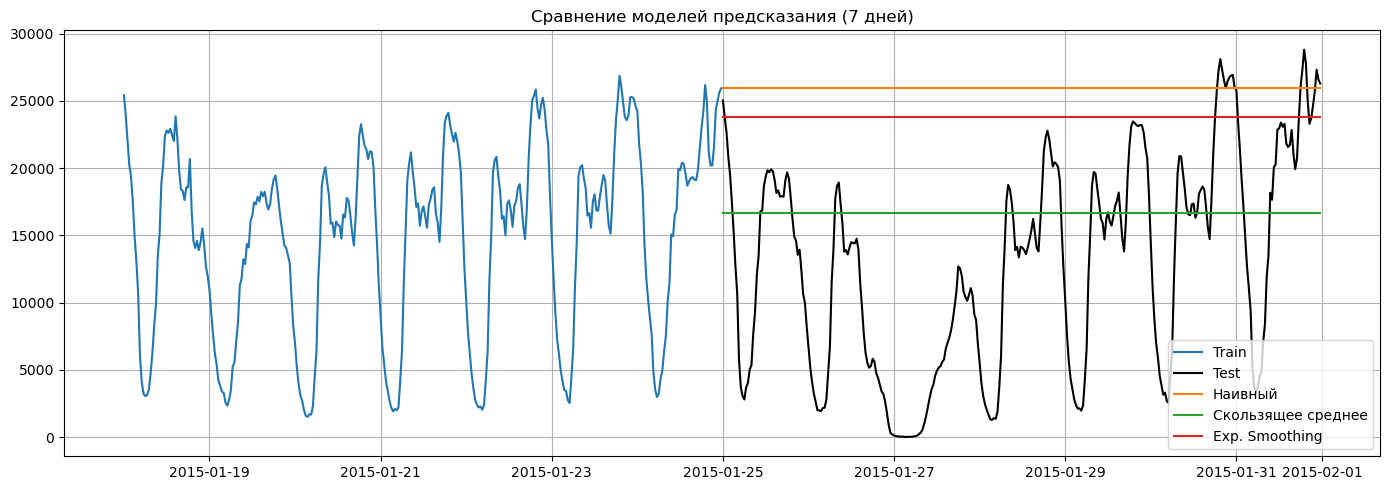

In [5]:
# Разделим данные: 7 дней * 48 точек = 336 последних значений на тест
test_size = 7 * 48
train, test = df[:-test_size], df[-test_size:]

# Метрики
def print_metrics(y_true, y_pred, label):
    print(f"\n{label}")
    print("MAE: ", mean_absolute_error(y_true, y_pred))
    print("RMSE:", root_mean_squared_error(y_true, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_true, y_pred) * 100)

# 1. Наивный прогноз
naive_pred = [train["value"].iloc[-1]] * len(test)

# 2. Скользящее среднее
ma_value = train["value"].rolling(window=48).mean().iloc[-1]
ma_pred = [ma_value] * len(test)

# 3. Экспоненциальное сглаживание
ses_model = SimpleExpSmoothing(
    train["value"], 
    initialization_method="estimated"
    ).fit(optimized=True, smoothing_level=0.2)
ses_pred = ses_model.forecast(len(test))

# Печатаем метрики
print_metrics(test["value"], naive_pred, "Наивный")
print_metrics(test["value"], ma_pred, "Скользящее среднее")
print_metrics(test["value"], ses_pred, "Экспоненциальное сглаживание")

# Визуализируем
plt.figure(figsize=(14, 5))
plt.plot(train.index[-test_size:], train["value"].iloc[-test_size:], label="Train")
plt.plot(test.index, test["value"], label="Test", color="black")
plt.plot(test.index, naive_pred, label="Наивный")
plt.plot(test.index, ma_pred, label="Скользящее среднее")
plt.plot(test.index, ses_pred, label="Exp. Smoothing")
plt.legend()
plt.title("Сравнение моделей предсказания (7 дней)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Модель SARIMA


Автоматический подбор параметров через pmdarima.auto_arima. 

Не сработало, тк крашиться ядро из-за нехватки ресурсов(

In [6]:
# # Автоматический подбор SARIMA-параметров
# model = auto_arima(
#     train["value"],
#     start_p=1, start_q=1,
#     max_p=3, max_q=3,
#     seasonal=True,
#     m=48,  # 48 шагов = 1 сутки (30 мин * 48 = 24 часа)
#     start_P=0, start_Q=0,
#     max_P=2, max_Q=2,
#     d=None, D=None,
#     trace=True,
#     error_action="ignore",
#     suppress_warnings=True,
#     stepwise=True
# )

# # Показываем модель и найденные параметры
# print(model.summary())

Построим графики ACF/PACF и сезонной декомпозиции

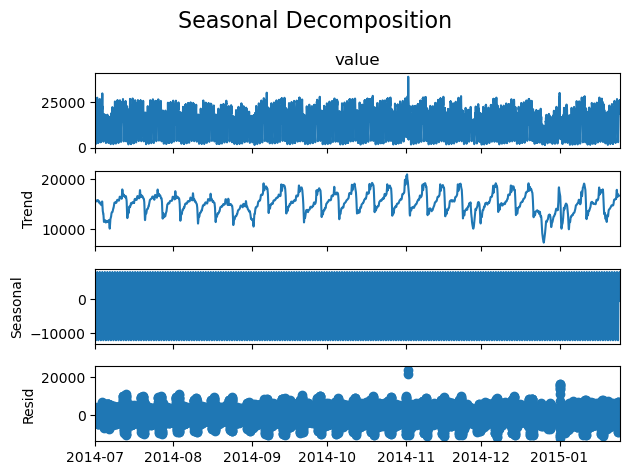

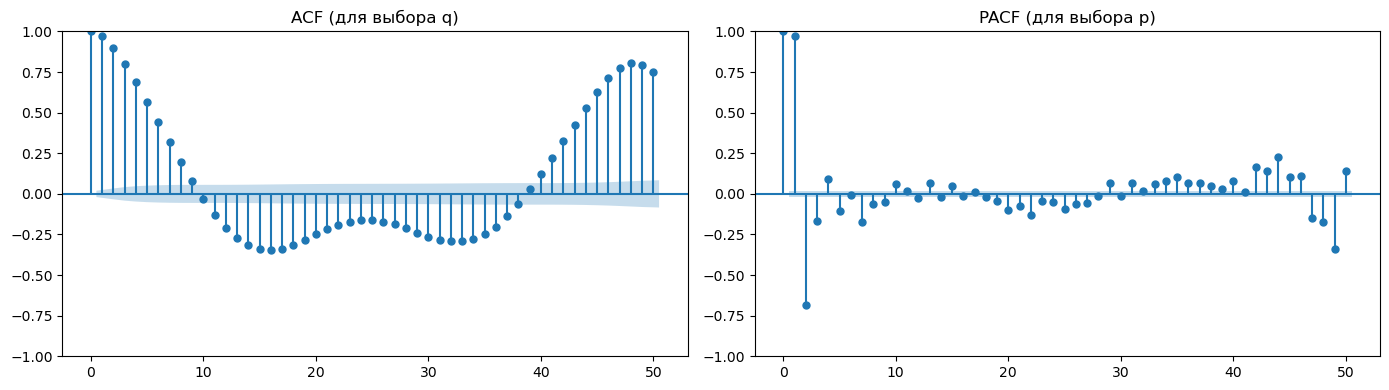

In [7]:
# Построим декомпозицию сезонности
decomp = seasonal_decompose(train["value"], period=48)
decomp.plot()
plt.suptitle("Seasonal Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

# ACF и PACF — для определения p и q
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(train["value"], lags=50, ax=axes[0])
plot_pacf(train["value"], lags=50, ax=axes[1])
axes[0].set_title("ACF (для выбора q)")
axes[1].set_title("PACF (для выбора p)")
plt.tight_layout()
plt.show()

In [8]:
# Подбор параметров
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 48)  # 48 — сезонность по суткам


SARIMA
MAE:  14073.499669496821
RMSE: 15450.015806396266
MAPE: 3713.3989314696137


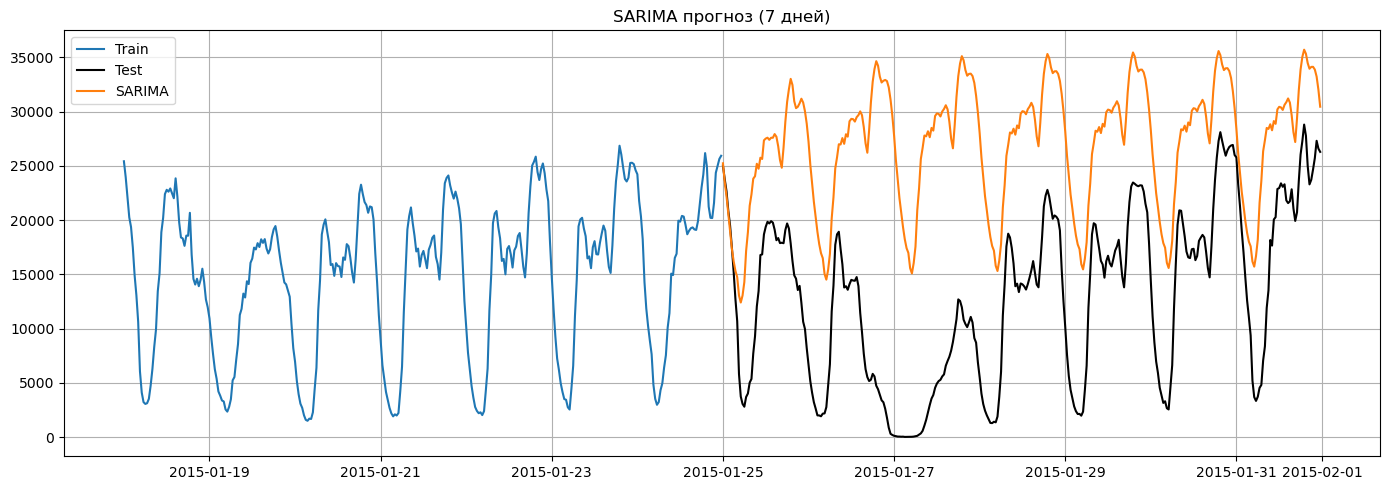

In [9]:
# Обучение модели
sarima_model = SARIMAX(train['value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 48)).fit(disp=False)

# Прогноз
sarima_pred = sarima_model.forecast(steps=len(test))

# Метрики
print("\nSARIMA")
print("MAE: ", mean_absolute_error(test['value'], sarima_pred))
print("RMSE:", root_mean_squared_error(test['value'], sarima_pred))
print("MAPE:", mean_absolute_percentage_error(test['value'], sarima_pred) * 100)

# Визуализация
plt.figure(figsize=(14, 5))
plt.plot(train.index[-len(test):], train["value"].iloc[-len(test):], label="Train")
plt.plot(test.index, test["value"], label="Test", color="black")
plt.plot(test.index, sarima_pred, label="SARIMA")
plt.legend()
plt.title("SARIMA прогноз (7 дней)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Произведем классификацию временного ряда, а именно к какой части суток(утро/день/вечер/ночь) относится отрезок. 
Ночь (00:00–06:00) 
Утро (06:00–12:00) 
День (12:00–18:00) 
Вечер (18:00–00:00) 

In [10]:
# Метки классов
def get_time_of_day(hour):
    if 0 <= hour < 6:
        return "night"
    elif 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "day"
    else:
        return "evening"

df["label"] = df.index.hour.map(get_time_of_day)
df["label"].value_counts()

label
night      2580
morning    2580
day        2580
evening    2580
Name: count, dtype: int64

In [11]:
window_size = 12  # 6 часов
X = []
y = []

for i in range(0, len(df) - window_size + 1, window_size):
    segment = df["value"].iloc[i:i + window_size].values
    label = df["label"].iloc[i]  # метка по первому часу окна
    X.append(segment)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("Форма X:", X.shape)
print("Примеры меток:", np.unique(y, return_counts=True))


Форма X: (860, 12)
Примеры меток: (array(['day', 'evening', 'morning', 'night'], dtype='<U7'), array([215, 215, 215, 215]))


## Классификация с помощью kNN + DTW

In [12]:
# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Обучаем kNN с DTW расстоянием
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")
knn_dtw.fit(X_train, y_train)

# Предсказания
y_pred = knn_dtw.predict(X_test)

# Оценка
print("Отчёт по kNN-DTW:\n")
print(classification_report(y_test, y_pred))

Отчёт по kNN-DTW:

              precision    recall  f1-score   support

         day       0.93      0.95      0.94        43
     evening       0.95      0.93      0.94        43
     morning       1.00      1.00      1.00        43
       night       1.00      1.00      1.00        43

    accuracy                           0.97       172
   macro avg       0.97      0.97      0.97       172
weighted avg       0.97      0.97      0.97       172



## Time Series Forest (TSF)

In [13]:
# sktime требует "nested" формат: каждая строка — pandas.Series
X_train_nested = from_2d_array_to_nested(X_train)
X_test_nested = from_2d_array_to_nested(X_test)

# Обучение
tsf = TimeSeriesForestClassifier(n_estimators=100, random_state=42)
tsf.fit(X_train_nested, y_train)

# Предсказания
y_pred_tsf = tsf.predict(X_test_nested)

# Оценка
print("Отчёт по Time Series Forest:\n")
print(classification_report(y_test, y_pred_tsf))

Отчёт по Time Series Forest:

              precision    recall  f1-score   support

         day       0.95      0.95      0.95        43
     evening       0.93      0.98      0.95        43
     morning       1.00      1.00      1.00        43
       night       1.00      0.95      0.98        43

    accuracy                           0.97       172
   macro avg       0.97      0.97      0.97       172
weighted avg       0.97      0.97      0.97       172



## ROCKET + логистическая регрессия

In [14]:
# Преобразуем данные в nested формат
X_train_nested = from_2d_array_to_nested(X_train)
X_test_nested = from_2d_array_to_nested(X_test)

# Применяем ROCKET трансформацию
rocket = Rocket(num_kernels=10_000, random_state=42)
rocket.fit(X_train_nested)

X_train_rocket = rocket.transform(X_train_nested)
X_test_rocket = rocket.transform(X_test_nested)

# Классификация: Ridge (или LogisticRegression)
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_rocket, y_train)

y_pred_rocket = classifier.predict(X_test_rocket)

# Оценка
print("Отчёт по ROCKET:\n")
print(classification_report(y_test, y_pred_rocket))

Отчёт по ROCKET:

              precision    recall  f1-score   support

         day       0.98      1.00      0.99        43
     evening       0.95      0.98      0.97        43
     morning       1.00      0.98      0.99        43
       night       1.00      0.98      0.99        43

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172



## Классификация сегментов временного ряда с помощью нейросети (библиотека tsai)

Импорт и загрузка

xb shape: torch.Size([64, 48, 1])
yb shape: torch.Size([64])
yb sample: tensor([0, 0, 0, 0, 0], device='cuda:0')


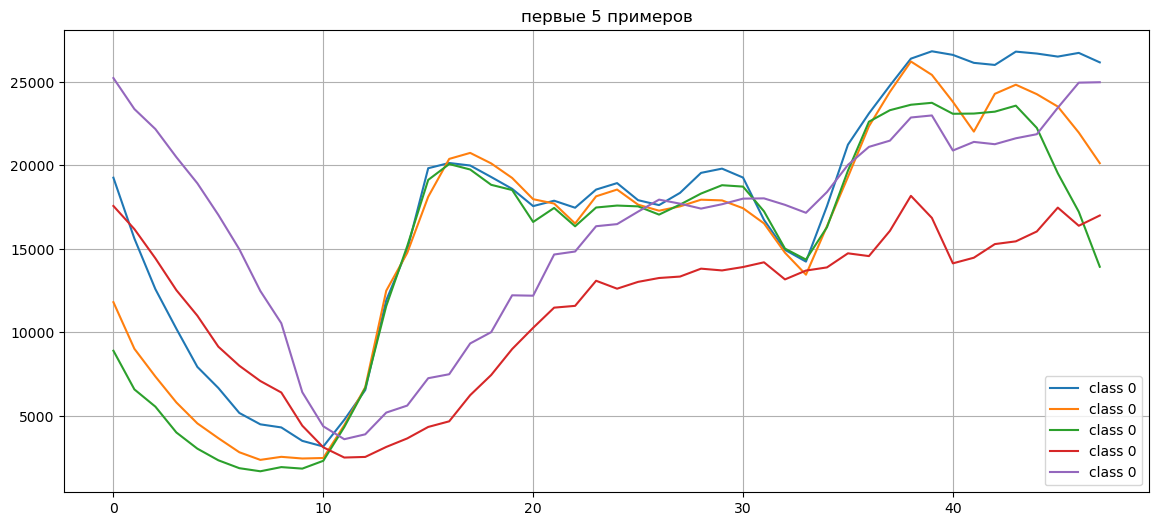

In [15]:
# from tsai.all import *
# from sklearn.preprocessing import LabelEncoder
# from tsai.data.core import TSDatasets, TSDataLoaders


segment_len = 48  # длина сегмента
X = []
y = []

for i in range(0, len(df) - segment_len, segment_len):
    segment = df['value'].iloc[i:i+segment_len].values
    hour = df.index[i + segment_len // 2].hour  # середина сегмента

    if 0 <= hour < 6:
        label = 'night'
    elif 6 <= hour < 12:
        label = 'morning'
    elif 12 <= hour < 18:
        label = 'day'
    else:
        label = 'evening'

    X.append(segment)
    y.append(label)

X = np.array(X).astype(np.float32)
y = np.array(y)

# Преобразуем строки меток в числа
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Переводим в формат tsai
X_torch = X[:, :, np.newaxis]  # [n_samples, time_steps, 1]
X_train_t, X_valid_t, y_train_t, y_valid_t = train_test_split(
    X_torch, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Добавим трансформацию стандартизации (по каналам)
tfms = [None, TSStandardize()]

# Создаём обучающую и валидационную выборки как TSDatasets
train_ds = TSDatasets(X_train_t, y_train_t, tfms=tfms)
valid_ds = TSDatasets(X_valid_t, y_valid_t, tfms=tfms)

# Загружаем в TSDataLoaders
dls = TSDataLoaders.from_dsets(train_ds, valid_ds, bs=64)

xb, yb = dls.one_batch()
print(f"xb shape: {xb.shape}")
print(f"yb shape: {yb.shape}")
print(f"yb sample: {yb[:5]}")

# Рисуем первые 5 примеров
plt.figure(figsize=(14, 6))
for i in range(5):
    plt.plot(xb[i, :, 0].cpu().numpy(), label=f"class {yb[i].item()}")
plt.title("первые 5 примеров")
plt.legend()
plt.grid(True)
plt.show()

#dls.show_batch()



Обучение модели

In [16]:
# Создаём Learner
learn = ts_learner(dls, InceptionTime, metrics=accuracy)

# Обучение модели
learn.fit_one_cycle(10, 1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.254697,16.782434,1.000000,00:00
1,0.229686,3.925542,1.000000,00:00
2,0.198810,2.405797,1.000000,00:00
3,0.170036,0.697208,1.000000,00:00
4,0.143849,0.353476,1.000000,00:00
5,0.126876,0.221923,1.000000,00:00
6,0.112275,0.127777,1.000000,00:00
7,0.101017,0.069834,1.000000,00:00
8,0.091721,0.061580,1.000000,00:00
9,0.083735,0.062756,1.000000,00:00


Визуализация

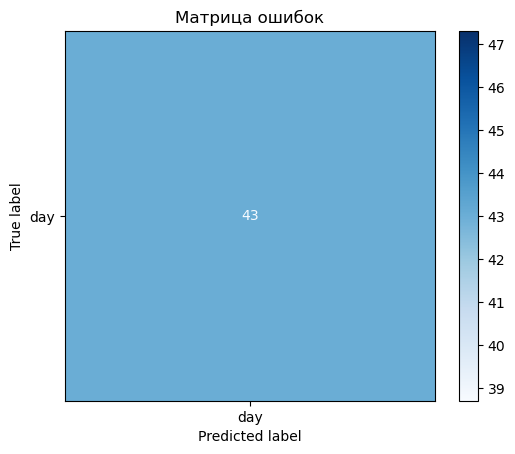

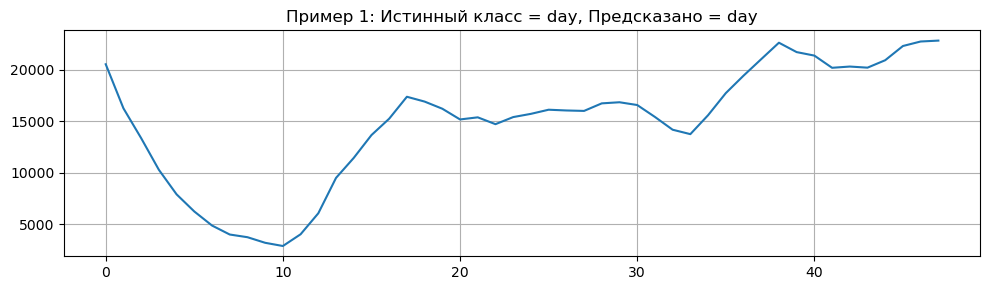

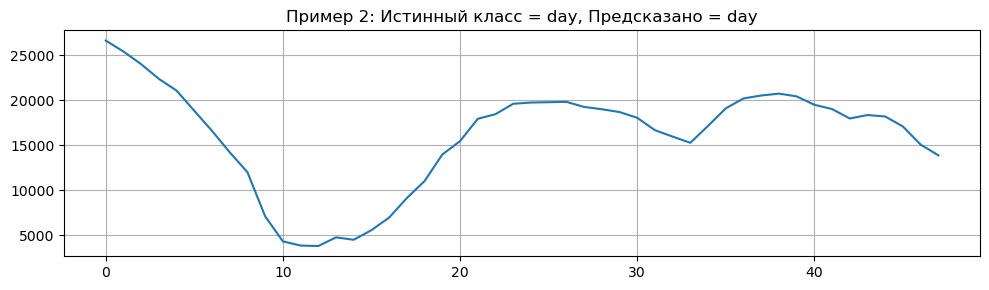

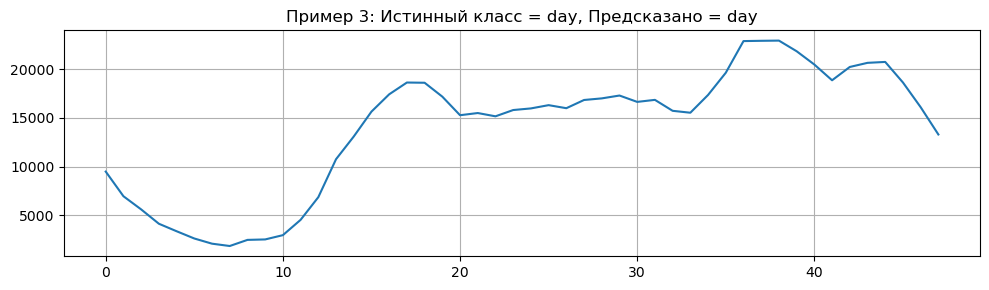

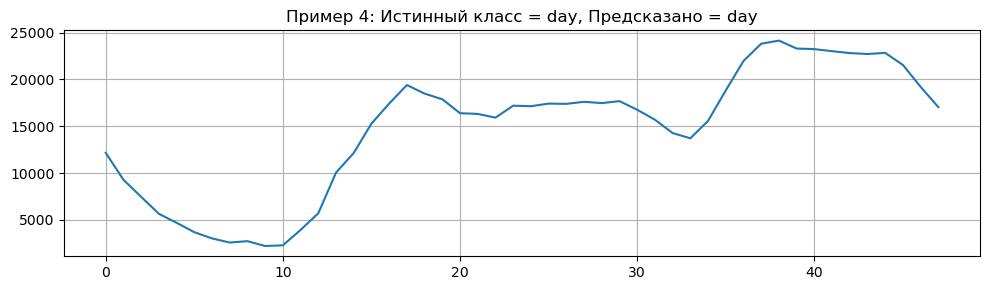

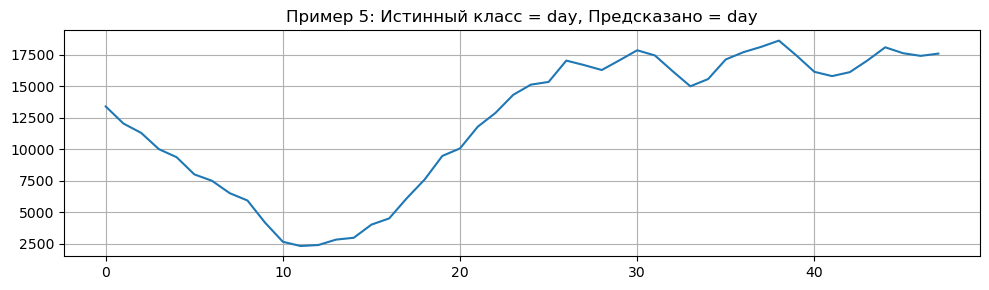

In [17]:
# Получаем предсказания на валидационной выборке
preds, targets = learn.get_preds()

# Преобразуем индексы в названия классов
y_pred = preds.argmax(dim=1).cpu().numpy()
y_true = targets.cpu().numpy()
class_names = le.classes_

# Строим матрицу
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Матрица ошибок")
plt.grid(False)
plt.show()

# Получим все предсказания
preds, targs = learn.get_preds()
y_pred_all = preds.argmax(dim=1).cpu().numpy()
y_true_all = targs.cpu().numpy()

# Визуализируем первые n примеров
n = 5
for i in range(n):
    plt.figure(figsize=(10, 3))
    plt.plot(X_valid_t[i].squeeze())  # сегмент
    true_label = le.inverse_transform([y_true_all[i]])[0]
    pred_label = le.inverse_transform([y_pred_all[i]])[0]
    plt.title(f"Пример {i+1}: Истинный класс = {true_label}, Предсказано = {pred_label}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Анализ аномалий

Z-Score

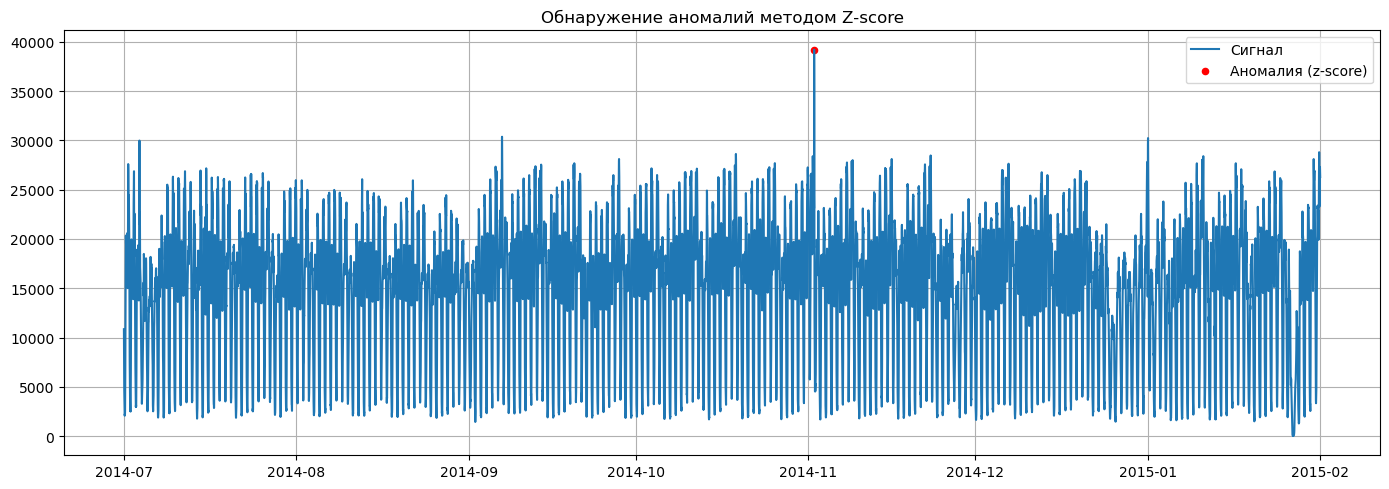

In [18]:
from scipy.stats import zscore

# Вычисляем z-оценки
df['z_score'] = zscore(df['value'])

# Выставим порог и найдём аномалии
threshold = 3
df['anomaly_z'] = df['z_score'].abs() > threshold

# Визуализация
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['value'], label='Сигнал')
plt.scatter(df[df['anomaly_z']].index, df[df['anomaly_z']]['value'],
            color='red', label='Аномалия (z-score)', s=20)
plt.title('Обнаружение аномалий методом Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Isolation Forest

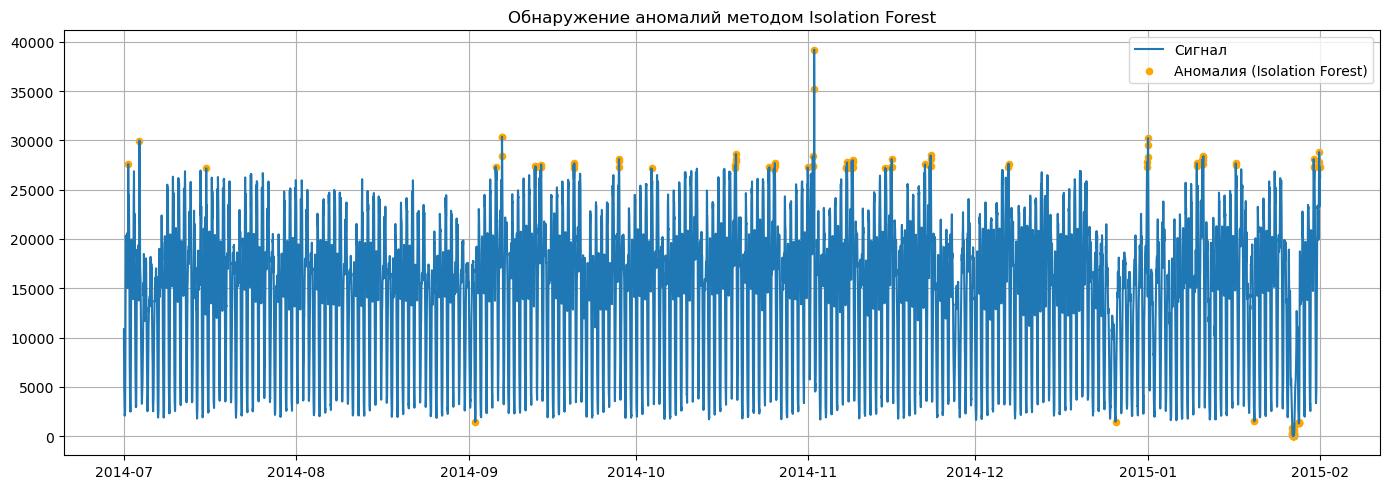

In [19]:
from sklearn.ensemble import IsolationForest

# Подготовка данных
X_iso = df[['value']].copy()

# Обучаем модель
model_iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_iso'] = model_iso.fit_predict(X_iso) == -1

# Визуализация
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['value'], label='Сигнал')
plt.scatter(df[df['anomaly_iso']].index, df[df['anomaly_iso']]['value'],
            color='orange', label='Аномалия (Isolation Forest)', s=20)
plt.title('Обнаружение аномалий методом Isolation Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


AutoEncoder

Обучение завершено.


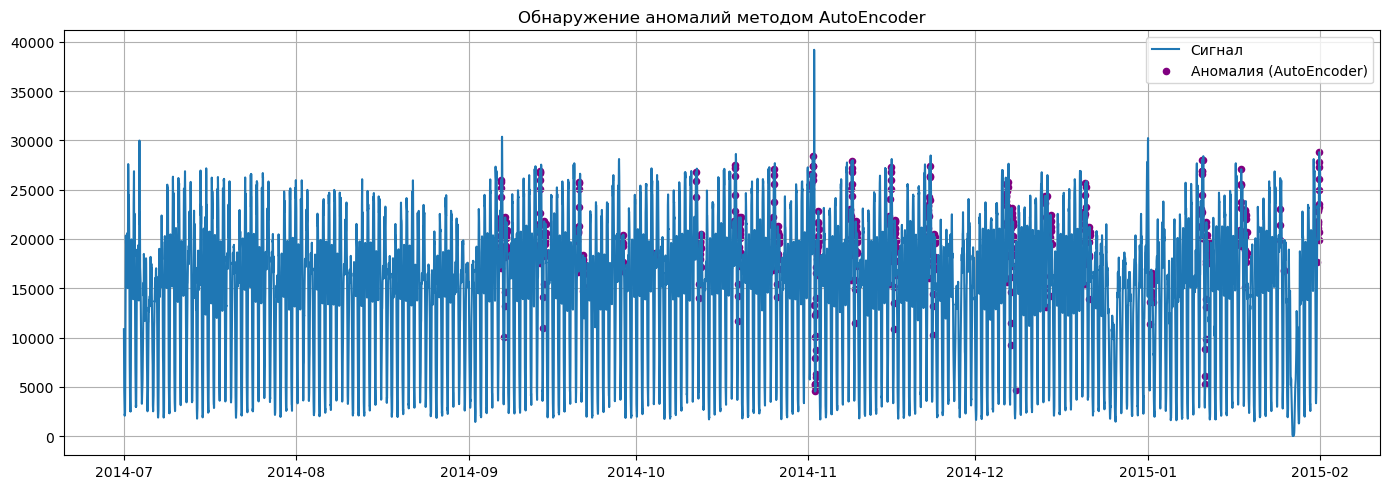

In [20]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Подготовим данные: сегменты по 48 точек
segment_len = 48
segments = []
for i in range(0, len(df) - segment_len):
    segment = df['value'].iloc[i:i+segment_len].values
    segments.append(segment)

segments = np.array(segments)

# Масштабируем
scaler = MinMaxScaler()
segments_scaled = scaler.fit_transform(segments)

# Преобразуем в torch.Tensor
X_tensor = torch.tensor(segments_scaled, dtype=torch.float32)

# Создадим простой автоэнкодер
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(48, 24), nn.ReLU(), nn.Linear(24, 12))
        self.decoder = nn.Sequential(nn.Linear(12, 24), nn.ReLU(), nn.Linear(24, 48))

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Обучение
model = AutoEncoder()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, X_tensor)
    loss.backward()
    optimizer.step()

print("Обучение завершено.")

# Получим ошибку восстановления
model.eval()
with torch.no_grad():
    recon = model(X_tensor).numpy()

errors = np.mean((segments_scaled - recon) ** 2, axis=1)

# Определим аномалии
threshold = np.percentile(errors, 95)
anomalies_ae = errors > threshold

# Подготовим даты
anomaly_indices = [df.index[i + segment_len] for i in range(len(anomalies_ae)) if anomalies_ae[i]]

# Визуализация
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['value'], label='Сигнал')
plt.scatter(anomaly_indices, df.loc[anomaly_indices]['value'], color='purple', label='Аномалия (AutoEncoder)', s=20)
plt.title("Обнаружение аномалий методом AutoEncoder")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
